In [ ]:
!pip install pyspark
!pip install xgboost


In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from IPython.display import display  # Pour une meilleure visualisation dans Google Colab

# Fixer une graine pour la reproductibilité
np.random.seed(42)

# Nombre de clients dans la base de données (10000 clients)
n_clients = 10000

# Générer des données aléatoires pour chaque variable explicative
age = np.random.randint(18, 70, n_clients)
revenu_annuel = np.random.randint(20000, 200000, n_clients)
historique_credit = np.random.randint(300, 850, n_clients)
montant_dettes = np.random.randint(0, 100000, n_clients)
duree_emploi = np.random.randint(0, 40, n_clients)
nombre_comptes = np.random.randint(1, 20, n_clients)
montant_pret = np.random.randint(1000, 100000, n_clients)
ratio_endettement = montant_dettes / revenu_annuel
type_pret = np.random.choice(['Hypothécaire', 'Personnel', 'Automobile'], size=n_clients)
statut_marital = np.random.choice(['Célibataire', 'Marié', 'Divorcé'], size=n_clients)
nombre_enfants = np.random.randint(0, 5, n_clients)
credit_accorde = ((ratio_endettement < 0.4) & (historique_credit > 650) & (revenu_annuel > 60000) &
                  (duree_emploi > 2)).astype(int)

# Créer un DataFrame pandas pour regrouper toutes ces variables
data = pd.DataFrame({
    'Age': age,
    'Revenu_annuel': revenu_annuel,
    'Historique_credit': historique_credit,
    'Montant_dettes': montant_dettes,
    'Duree_emploi': duree_emploi,
    'Nombre_comptes': nombre_comptes,
    'Montant_pret': montant_pret,
    'Ratio_endettement': ratio_endettement,
    'Type_pret': type_pret,
    'Statut_marital': statut_marital,
    'Nombre_enfants': nombre_enfants,
    'Credit_accorde': credit_accorde
})

# Afficher le DataFrame complet sous forme de tableau interactif dans Google Colab
display(data)


,Age,Revenu_annuel,Historique_credit,Montant_dettes,Duree_emploi,Nombre_comptes,Montant_pret,Ratio_endettement,Type_pret,Statut_marital,Nombre_enfants,Credit_accorde
0,56,161002,713,35215,10,8,49438,0.218724,Automobile,Divorcé,3,1
1,69,23285,372,87564,0,4,99564,3.760533,Automobile,Divorcé,4,0
2,46,143637,846,96845,15,2,32812,0.674234,Hypothécaire,Divorcé,2,0
3,32,55863,597,41078,24,6,29709,0.735335,Hypothécaire,Divorcé,4,0
4,60,167776,582,36264,37,3,71721,0.216145,Personnel,Marié,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,55,141184,516,40345,35,4,60816,0.285762,Automobile,Marié,0,0
9996,51,136524,495,71266,25,11,81480,0.522003,Personnel,Divorcé,2,0
9997,57,136826,500,8476,19,9,59420,0.061947,Personnel,Célibataire,3,0
9998,64,56775,665,40755,33,16,76148,0.717834,Personnel,Divorcé,2,0


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


Matrice de confusion:
[[1741    0]
 [   2 1709]]

Rapport de classification:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1741
           1       1.00      1.00      1.00      1711

    accuracy                           1.00      3452
   macro avg       1.00      1.00      1.00      3452
weighted avg       1.00      1.00      1.00      3452


Scores de validation croisée F1: [0.99593968 0.9997104  0.99826489 0.99942096 1.        ]
Moyenne des scores de validation croisée F1: 0.9986671852273187


<Figure size 1000x600 with 0 Axes>

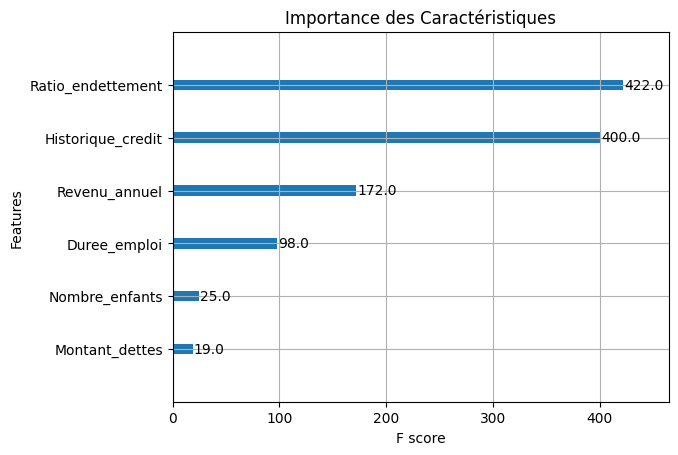

In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from xgboost import plot_importance
import warnings

# Suppression des avertissements concernant `use_label_encoder`
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Sélectionner les variables explicatives (features) et la variable cible (target)
X = data.drop('Credit_accorde', axis=1)  # Variables explicatives
y = data['Credit_accorde']  # Variable cible

# Convertir les variables catégorielles en variables indicatrices (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Équilibrage des classes avec SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Diviser le dataset équilibré en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Définir les paramètres pour GridSearch
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, 2, 5]  # Ajustement pour le déséquilibre
}

# Initialiser le modèle XGBoost
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

# Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur modèle après GridSearch
best_model = grid_search.best_estimator_

# Évaluation du modèle sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Afficher la matrice de confusion et le rapport de classification
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

# Évaluer la performance via validation croisée
cv_scores = cross_val_score(best_model, X_balanced, y_balanced, cv=5, scoring='f1')
print("\nScores de validation croisée F1:", cv_scores)
print("Moyenne des scores de validation croisée F1:", np.mean(cv_scores))

# Visualisation de l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plot_importance(best_model, importance_type='weight')
plt.title('Importance des Caractéristiques')
plt.show()


Accuracy: 0.9825372367745249
F1 Score: 0.982871861916546

Matrice de confusion:
prediction       0.0  1.0
Credit_accorde           
0               1666   29
1                  5  247


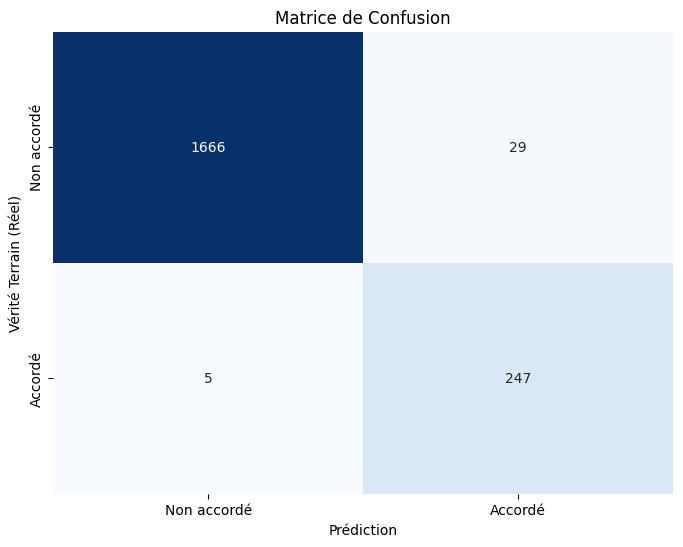

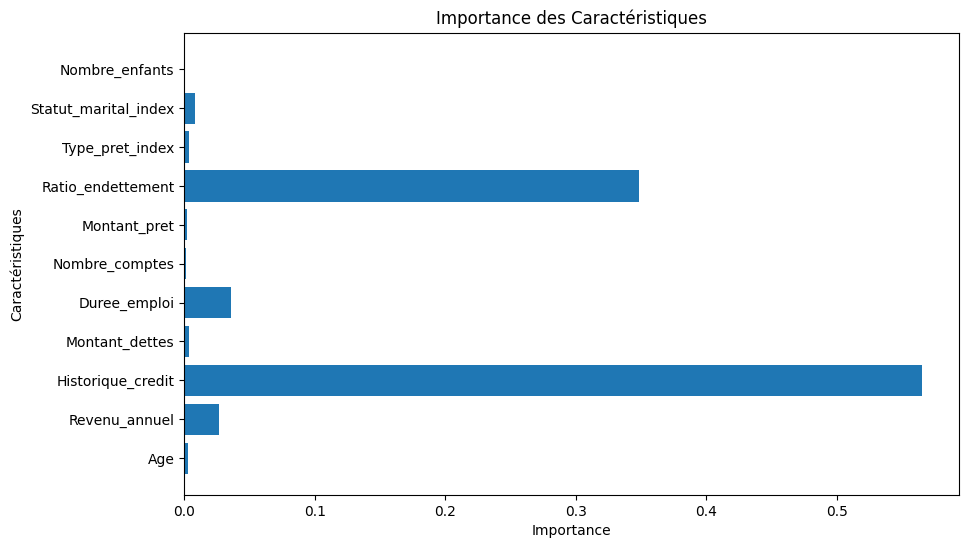

In [ ]:
# Importer les bibliothèques nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppression des avertissements concernant `use_label_encoder`
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Initialiser Spark
spark = SparkSession.builder.appName("CreditPrediction").getOrCreate()

# Convertir le DataFrame Pandas en DataFrame Spark
data_spark = spark.createDataFrame(data)

# Indexer les variables catégorielles
indexer_type_pret = StringIndexer(inputCol='Type_pret', outputCol='Type_pret_index')
indexer_statut_marital = StringIndexer(inputCol='Statut_marital', outputCol='Statut_marital_index')

data_spark = indexer_type_pret.fit(data_spark).transform(data_spark)
data_spark = indexer_statut_marital.fit(data_spark).transform(data_spark)

# Sélectionner les variables explicatives (features) et la variable cible (target)
feature_columns = ['Age', 'Revenu_annuel', 'Historique_credit', 'Montant_dettes',
                   'Duree_emploi', 'Nombre_comptes', 'Montant_pret', 'Ratio_endettement',
                   'Type_pret_index', 'Statut_marital_index', 'Nombre_enfants']

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data_transformed = assembler.transform(data_spark)

# Diviser le dataset en ensembles d'entraînement et de test
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)

# Équilibrage des classes avec SMOTE
train_pdf = train_data.toPandas()
X_train = train_pdf[feature_columns]
y_train = train_pdf['Credit_accorde']

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

# Convertir les données équilibrées en DataFrame Spark
balanced_data = pd.DataFrame(X_balanced)
balanced_data['Credit_accorde'] = y_balanced
balanced_spark_df = spark.createDataFrame(balanced_data)

# Reassembler les caractéristiques
balanced_data_transformed = assembler.transform(balanced_spark_df)

# Définir le modèle GBT
gbt = GBTClassifier(featuresCol='features', labelCol='Credit_accorde', maxIter=10)

# Entraîner le modèle
gbt_model = gbt.fit(balanced_data_transformed)

# Prédire sur l'ensemble de test
predictions = gbt_model.transform(test_data)

# Évaluation du modèle
evaluator = MulticlassClassificationEvaluator(labelCol='Credit_accorde', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol='Credit_accorde', predictionCol='prediction', metricName='f1')
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1_score}")

# Matrice de confusion
confusion_matrix = predictions.groupBy('Credit_accorde', 'prediction').count().toPandas()
confusion_matrix = confusion_matrix.pivot(index='Credit_accorde', columns='prediction', values='count').fillna(0)

print("\nMatrice de confusion:")
print(confusion_matrix)

# Tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap='Blues', cbar=False, xticklabels=['Non accordé', 'Accordé'], yticklabels=['Non accordé', 'Accordé'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité Terrain (Réel)')
plt.show()

# Importance des caractéristiques
importances = gbt_model.featureImportances

# Visualiser l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.barh(feature_columns, importances)
plt.title('Importance des Caractéristiques')
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.show()

# Arrêter la session Spark
spark.stop()


In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from IPython.display import display  # Pour une meilleure visualisation dans Google Colab

# Fixer une graine pour la reproductibilité
np.random.seed(42)

# Nombre de clients dans la base de données (10000 clients)
n_clients = 10000

# Générer des données aléatoires pour chaque variable explicative
age = np.random.randint(18, 70, n_clients)
revenu_annuel = np.random.randint(20000, 200000, n_clients)
historique_credit = np.random.randint(300, 850, n_clients)
montant_dettes = np.random.randint(0, 100000, n_clients)
duree_emploi = np.random.randint(0, 40, n_clients)
nombre_comptes = np.random.randint(1, 20, n_clients)
montant_pret = np.random.randint(1000, 100000, n_clients)
ratio_endettement = montant_dettes / revenu_annuel
type_pret = np.random.choice(['Hypothécaire', 'Personnel', 'Automobile'], size=n_clients)
statut_marital = np.random.choice(['Célibataire', 'Marié', 'Divorcé'], size=n_clients)
nombre_enfants = np.random.randint(0, 5, n_clients)
credit_accorde = ((ratio_endettement < 0.4) & (historique_credit > 650) & (revenu_annuel > 60000) &
                  (duree_emploi > 2)).astype(int)

# Créer un DataFrame pandas pour regrouper toutes ces variables
data = pd.DataFrame({
    'Age': age,
    'Revenu_annuel': revenu_annuel,
    'Historique_credit': historique_credit,
    'Montant_dettes': montant_dettes,
    'Duree_emploi': duree_emploi,
    'Nombre_comptes': nombre_comptes,
    'Montant_pret': montant_pret,
    'Ratio_endettement': ratio_endettement,
    'Type_pret': type_pret,
    'Statut_marital': statut_marital,
    'Nombre_enfants': nombre_enfants,
    'Credit_accorde': credit_accorde
})

# Filtrer les clients qui ont eu un crédit accordé
clients_avec_credit = data[data['Credit_accorde'] == 1]

# Afficher les clients avec crédit accordé
print("Clients ayant eu un crédit accordé :")
display(clients_avec_credit)


Clients ayant eu un crédit accordé :


,Age,Revenu_annuel,Historique_credit,Montant_dettes,Duree_emploi,Nombre_comptes,Montant_pret,Ratio_endettement,Type_pret,Statut_marital,Nombre_enfants,Credit_accorde
0,56,161002,713,35215,10,8,49438,0.218724,Automobile,Divorcé,3,1
5,25,169777,804,34484,17,14,63938,0.203113,Personnel,Divorcé,2,1
16,20,198780,790,65294,22,10,56394,0.328474,Personnel,Divorcé,2,1
22,55,87863,723,6773,17,11,63386,0.077086,Automobile,Célibataire,1,1
23,19,117927,846,14205,4,1,34934,0.120456,Personnel,Marié,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9959,60,146560,691,38805,9,11,37980,0.264772,Personnel,Marié,1,1
9977,24,175304,726,46686,39,5,14204,0.266315,Personnel,Célibataire,0,1
9978,47,190484,787,47193,19,10,29878,0.247753,Personnel,Divorcé,1,1
9994,41,94861,774,16918,38,10,69493,0.178345,Automobile,Divorcé,4,1
